In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
pip install plotly

Partie 2: Using neural networks, predicting stock prices. Comparaison of ARIMA process, RNN, LSTM and GRU

In [2]:
NVDA = yf.download('NVDA', start = '2019-01-01', end = '2022-12-31', progress = False).round(2)

In [3]:
data = NVDA[['Adj Close', 'Open','High', 'Low', 'Close', 'Volume']]

In [4]:
data.isna().sum()

Adj Close    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


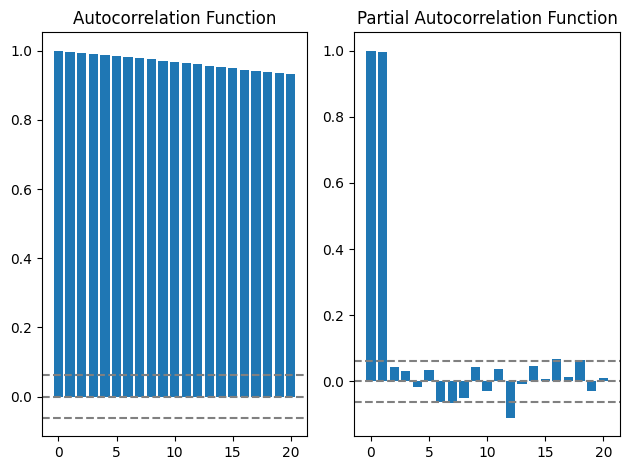

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1008
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3091.618
Date:                Thu, 25 May 2023   AIC                           6195.235
Time:                        08:38:47   BIC                           6224.730
Sample:                             0   HQIC                          6206.441
                               - 1008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        130.5095     44.993      2.901      0.004      42.324     218.695
ar.L1          0.1973      0.097      2.037      0.042       0.007       0.387
ar.L2          0.7987      0.097      8.238      0.0

In [5]:
#Let's start with the ARIMA Process as it is the simplest thing to do. 
#First, find what AR and MA lags do we need, then we can use the ARIMA process
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic, acf, pacf

res = arma_order_select_ic(data['Adj Close'], ic='aic', trend='n')
optimal_ar = res['aic_min_order'][0]
optimal_ma = res['aic_min_order'][1]

# Plot the ACF and PACF for the data
lag_acf = acf(data['Adj Close'], nlags=20)
lag_pacf = pacf(data['Adj Close'], nlags=20, method='ols')

plt.subplot(121)
plt.bar(x=range(len(lag_acf)), height=lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data['Adj Close'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data['Adj Close'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.bar(x=range(len(lag_pacf)), height=lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data['Adj Close'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data['Adj Close'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

# Fit the ARIMA model with the optimal lags
model = ARIMA(data['Adj Close'], order=(optimal_ar, 0, optimal_ma))
results = model.fit()

# Print the model summary
print(results.summary())

In [22]:
size_train = int(len(data) * 0.8)
size_test = int(len(data) * 0.2)
num_steps = 5
num_periods = 2

training_set = data.iloc[:size_train, 0:1].values
testing_set = data.iloc[size_train:, 0:1].values 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit(training_set)
scaled_train = scaled.transform(training_set) 

X_train = []
y_train = []
for i in range(num_steps, size_train-1):
  X_train.append(scaled_train[i-num_steps:i, 0])
  y_train.append(scaled_train[i:i+num_periods, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
data_concat = pd.concat((data['Adj Close'][:size_train], data['Adj Close'][size_train:]), axis=0)
data_input = data_concat[len(data_concat)-len(testing_set)-num_steps:]
data_input = data_input.values.reshape(-1, 1)
data_input = scaler.transform(data_input)

X_test = []
for i in range(num_steps, size_test + num_steps - num_periods):
  X_test.append(data_input[i-num_steps:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



In [23]:
X_train_df = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_df = pd.DataFrame(y_train)
concatenated_train = pd.concat([X_train_df, y_train_df], axis=1)

X_test_df = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
concatenated_test = pd.DataFrame(X_test_df)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

X_columns = ['x(t-4)', 'x(t-3)', 'x(t-2)', 'x(t-1)', 'x(t)']
y_columns = ['y(t+1)', 'y(t+2)']

X_train_df.columns = X_columns
X_test_df.columns = X_columns
y_train_df.columns = y_columns


There are 800 samples in the training data
There are 199 samples in the test data


In [24]:
X_test_df

,x(t-4),x(t-3),x(t-2),x(t-1),x(t)
0,0.607381,0.657084,0.645280,0.626778,0.601280
1,0.657084,0.645280,0.626778,0.601280,0.655725
2,0.645280,0.626778,0.601280,0.655725,0.706157
3,0.626778,0.601280,0.655725,0.706157,0.715110
4,0.601280,0.655725,0.706157,0.715110,0.770980
...,...,...,...,...,...
194,0.493816,0.480619,0.456680,0.444047,0.433536
195,0.480619,0.456680,0.444047,0.433536,0.427932
196,0.456680,0.444047,0.433536,0.427932,0.441726
197,0.444047,0.433536,0.427932,0.441726,0.403196


In [32]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(LSTM(units = 50, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 2))

model.compile(optimizer = Adam(learning_rate=0.008, decay=1e-8), loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)

pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)

7/7 [==============================] - 2s 6ms/step


In [33]:

prediction_df = pd.DataFrame(columns = ['Actual', 'Predicted LSTM'])
prediction_df['Actual'] = data['Adj Close'].iloc[size_train:][0:len(pred)]
prediction_df['Predicted LSTM'] = pred[:,0]


In [34]:
fig_pred = go.Figure()
fig_pred.add_trace(go.Scatter(x = prediction_df.index, y = prediction_df['Actual'], name = 'Actual'))
fig_pred.add_trace(go.Scatter(x = prediction_df.index, y = prediction_df['Predicted LSTM'], name = 'Predicted LSTM'))
fig_pred.show()

In [35]:
mse = MeanSquaredError()
mse.update_state(prediction_df['Actual'], prediction_df['Predicted LSTM'])
lstm_mse = mse.result().numpy()
print(f'The mean squared error for the LSTM method is {lstm_mse}')

The mean squared error for the LSTM method is 159.1624298095703


In [37]:
#Now on to the RNN model
model_2 = Sequential()

model_2.add(SimpleRNN(units = 32, return_sequences = True, activation = 'tanh'))
model_2.add(SimpleRNN(units = 32, return_sequences = True, activation = 'tanh'))
model_2.add(SimpleRNN(units = 32, return_sequences = True, activation = 'tanh'))
model_2.add(SimpleRNN(units = 32))
model_2.add(Dropout(0.2))
model_2.add(Dense(2))

model_2.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_2.fit(X_train, y_train, epochs = 100, batch_size = 150, verbose = 0) 
Pred_RNN = model_2.predict(X_test)
Pred_RNN = scaler.inverse_transform(Pred_RNN)

7/7 [==============================] - 0s 4ms/step


In [38]:
prediction_df['Predicted RNN'] = Pred_RNN[:,0]
fig_pred.add_trace(go.Scatter(x = prediction_df.index, y = prediction_df['Predicted RNN'], name = 'Predicted RNN'))

In [39]:
mse.update_state(prediction_df['Actual'], prediction_df['Predicted RNN'])
rnn_mse = mse.result().numpy()
print(f'The mean squared error for the RNN method is {rnn_mse}')

The mean squared error for the RNN method is 190.70892333984375


In [40]:
#Last but not least, GRU
from keras.layers import GRU
from keras.optimizers import SGD

model_3 = Sequential()
model_3.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model_3.add(Dropout(0.2))
model_3.add(GRU(units=50, return_sequences=True, activation='tanh'))
model_3.add(Dropout(0.2))
model_3.add(GRU(units=50, return_sequences=True, activation='tanh'))
model_3.add(Dropout(0.2))
model_3.add(GRU(units=50, activation='tanh'))
model_3.add(Dropout(0.2))
model_3.add(Dense(units=2))

model_3.compile(optimizer= 'adam',loss='mean_squared_error')
model_3.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

GRU_pred = model_3.predict(X_test)
GRU_pred = scaler.inverse_transform(GRU_pred)


7/7 [==============================] - 1s 5ms/step


In [41]:
prediction_df['Predicted GRU'] = GRU_pred[:,0]
fig_pred.add_trace(go.Scatter(x = prediction_df.index, y = prediction_df['Predicted GRU'], name = 'Predicted GRU'))
fig_pred.show()

In [42]:
mse.update_state(prediction_df['Actual'], prediction_df['Predicted GRU'])
gru_mse = mse.result().numpy()
print(f'The mean squared error for the GRU method is {gru_mse}')

The mean squared error for the GRU method is 182.7322998046875


In [43]:
mse_dict = {'LSTM':lstm_mse.round(2),'RNN':rnn_mse.round(2),'GRU':gru_mse.round(2)}

In [44]:
for key, value in mse_dict.items():
  print(key, value)

LSTM 159.16
RNN 190.71
GRU 182.73


Changer un peu les noms et les valeurs utilisées pour fit les NN et ensuite, écrire un paper dessus lol et ensuite on peut poster !